In [2]:
import models
import evaluation

import torch
from torch import nn
from torchvision import transforms, utils
from PIL import Image
import numpy as np
import math
from tqdm import tqdm
from IPython.display import display
from itertools import cycle
from typing import Tuple
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import statsmodels.api as sm
from scipy.stats import genextreme, shapiro, beta, genpareto, rv_continuous, entropy
from scipy.optimize import minimize

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
class ToTensor(object):
    def __call__(self, sample):
        ts = sample['ts']

        return {'ts': torch.from_numpy(ts)}

# STEP 1: i.i.d. Gaussian

In [4]:
# Set a seed for reproducibility
np.random.seed(42)

# Generate 10,000 random points from a normal distribution
mean = 0
std_dev = 1
sample_size = 100000
random_points = np.random.normal(mean, std_dev, sample_size)

## Estimate parameters ($\mu$, $\sigma^2$)

In [5]:
e_mu = random_points.mean()
e_sigma_2 = random_points.var()
print("μ  = {}".format(e_mu))
print("σ2 = {}".format(e_sigma_2))

μ  = 0.000966868140949598
σ2 = 1.0018027203084223


In [ ]:
gen_sample_size = 5000
uniform_points = np.random.uniform(0, 1, gen_sample_size)
normal_samples = np.random.normal(e_mu, np.sqrt(e_sigma_2), gen_sample_size)

# Shapiro-Wilk test
statistic, p_value = shapiro(normal_samples)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Histogram on subplot 1
ax1.hist(normal_samples, bins=50, density=True, alpha=0.7, label='Generated Normal Samples')
ax1.set_title('Generated Normal Samples using Inverse Parametric CDF')
ax1.set_xlabel('Value')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.grid(True)

# Q-Q plot on subplot 2
sm.qqplot(normal_samples, line='45', ax=ax2)
ax2.set_title('Q-Q Plot')
annotation = ax2.annotate(
    f"Shapiro-Wilk Test:\nStatistic: {statistic:.4f}\np-value: {p_value:.4f}",
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    horizontalalignment='left',
    verticalalignment='top',
    fontsize=10,
    bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.7)
)

plt.tight_layout()
plt.show()

## Estimate parameters (param.: GEV, Beta, GLC)

In [ ]:
# params = genextreme.fit(random_points)
params = beta.fit(random_points)

x_theoretical = np.sort(random_points)
y_theoretical = beta.cdf(x_theoretical, *params)

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y

x_ecdf, y_ecdf = ecdf(random_points)

# Plot the empirical CDF and the fitted parametric CDF
plt.figure(figsize=(10, 6))
plt.step(x_ecdf, y_ecdf, label='Empirical CDF')
plt.plot(x_theoretical, y_theoretical, label='Fitted Parametric CDF')
plt.title('Empirical Cumulative Distribution Function (ECDF) and Fitted Parametric CDF')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(params)

# MIRAR: Parametres canvien moltíssim segons canviem la seed

In [ ]:
gen_sample_size = 5000
uniform_points = np.random.uniform(0, 1, gen_sample_size)
normal_samples = beta.ppf(uniform_points, *params)

# Shapiro-Wilk test
statistic, p_value = shapiro(normal_samples)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Histogram on subplot 1
ax1.hist(normal_samples, bins=50, density=True, alpha=0.7, label='Generated Normal Samples')
ax1.set_title('Generated Normal Samples using Inverse Parametric CDF')
ax1.set_xlabel('Value')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.grid(True)

# Q-Q plot on subplot 2
sm.qqplot(normal_samples, line='45', ax=ax2)
ax2.set_title('Q-Q Plot')
annotation = ax2.annotate(
    f"Shapiro-Wilk Test:\nStatistic: {statistic:.4f}\np-value: {p_value:.4f}",
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    horizontalalignment='left',
    verticalalignment='top',
    fontsize=10,
    bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.7)
)

plt.tight_layout()
plt.show()

## GenNN

In [ ]:
class NormalIIDDataset(Dataset):
    """Normal I.I.D. dataset."""

    def __init__(self, random_points, transform=None):
        self.random_points = torch.tensor(random_points, dtype=torch.float32)
        self.transform = transform

    def __len__(self):
        return len(self.random_points)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.random_points[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
dataset = NormalIIDDataset(random_points)

bsz = 64
dataloader = DataLoader(dataset, batch_size=bsz, shuffle=True)

print(next(iter(dataloader)))  # Print first sample

In [33]:
class Generator(torch.nn.Module):
    def __init__(self, noise_size: int, ts_size: int):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=noise_size, out_features=20),
            nn.Tanh(),
        )
        self.fc2 = nn.Linear(in_features=20, out_features=ts_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.fc2(x)

        return x


class GeneratorMlp(torch.nn.Module):
    def __init__(self, noise_size: int, ts_size: int):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=noise_size, out_features=max(ts_size//4, 1)),
            nn.Tanh()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=max(ts_size//4, 1), out_features=max(ts_size//2, 1)),
            nn.Tanh()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=max(ts_size//2, 1), out_features=ts_size),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


class GeneratorMlpBatchnorm(torch.nn.Module):
    def __init__(self, noise_size: int, ts_size: int):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=noise_size, out_features=max(ts_size//64, 1)),
            nn.BatchNorm1d(1),
            nn.Tanh()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=max(ts_size//64, 1), out_features=max(ts_size//4, 1)),
            nn.BatchNorm1d(1),
            nn.Tanh()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=max(ts_size//4, 1), out_features=ts_size),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


class GeneratorCnn(torch.nn.Module):
    def __init__(self, noise_size: int, ts_size: int):
        super().__init__()
        self.linear = nn.Linear(in_features=noise_size, out_features=max(-(ts_size//-64), 1))  # ceiling division
        self.tconv1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=20, padding="same"),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2)
        )
        self.tconv2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=15, padding="same"),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2)
        )
        self.tconv3 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=10, padding="same"),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2)
        )
        self.tconv4 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=10, padding="same"),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2)
        )
        self.tconv5 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=10, padding="same"),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2)
        )
        self.tconv6 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=10, padding="same"),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=7, padding="same"),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5, padding="same"),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2)
        )
        self.proj = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=1, kernel_size=1, padding="same"),
            nn.Linear(in_features=max(-(ts_size//-64), 1)*2**6, out_features=ts_size),
            # nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear(x)

        if x.dim() == 1:
            # Add batch dimension
            x = x.unsqueeze(0)

        # Add channel dimension
        x = x.unsqueeze(1)

        x = self.tconv1(x)
        x = self.tconv2(x)
        x = self.tconv3(x)
        x = self.tconv4(x)
        x = self.tconv5(x)
        x = self.tconv6(x)

        x = self.proj(x)

        x = torch.squeeze(x)
        return x


class Discriminator(torch.nn.Module):
    def __init__(self, ts_size: int):
        super().__init__()
        self.ts_size = ts_size
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=ts_size, out_features=1),
            nn.Sigmoid(), # Binary classification (real vs false)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape(-1, self.ts_size)
        x = self.fc1(x)

        return x

class DiscriminatorMlpCnn(nn.Module):
    def __init__(self, ts_size: int):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=10, padding="same"),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=10, padding="same"),
            nn.LeakyReLU(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=10, padding="same"),
            nn.LeakyReLU(0.2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64 * ts_size, out_features=3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=3, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unsqueeze(1)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        bsz, nch, ts_len = x.shape
        x = x.reshape(bsz, nch * ts_len)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [ ]:
def simplified_experiment(G, D, hparams, scheduler=False):
    generator = G(hparams['noise_size'], hparams['ts_size']).to(device)
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])
    scheduler_g = torch.optim.lr_scheduler.StepLR(optimizer_g, step_size=hparams['step_size_lr_scheduler_g'], gamma=hparams['gamma_g'])

    discriminator = D(hparams['ts_size']).to(device)
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])
    scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_d, step_size=hparams['step_size_lr_scheduler_d'], gamma=hparams['gamma_d'])

    criterion = nn.BCELoss()

    # Train function
    def train_batch(real_samples: torch.Tensor, generator: torch.nn.Module, discriminator: torch.nn.Module, optimizer_g: torch.optim, optimizer_d: torch.optim) -> Tuple[float, float, int, int, int, int, int]:
        generator.train()
        discriminator.train()

        bsz = real_samples.shape[0]

        # Real (ones) and Fake (zeros)
        label_real = torch.ones([bsz, 1])
        label_fake = torch.zeros([bsz, 1])

        label_real = label_real.to(device)
        label_fake = label_fake.to(device)

        ########################
        # OPTIMIZE DISCRIMINATOR
        ########################

        bd_hits_real = 0
        bd_hits_fake = 0
        bd_attempts = bsz * hparams['disc_ratio']

        for _ in range(hparams['disc_ratio']):
            # Generate fake samples
            z = torch.randn(bsz, hparams['noise_size'], device=device)
            fake_samples = generator(z)
            fake_samples = fake_samples.detach() # Freeze the generator

            # Reset gradients
            optimizer_d.zero_grad()

            # Calculate discriminator prediction, loss and #correct predictions for real samples
            predictions_d_real = discriminator(real_samples)
            loss_d_real = criterion(predictions_d_real, label_real)
            bd_hits_real += (predictions_d_real >= 0.5).sum().item()

            # Calculate discriminator prediction, loss and #correct predictions for fake samples
            predictions_d_fake = discriminator(fake_samples)
            loss_d_fake = criterion(predictions_d_fake, label_fake)
            bd_hits_fake += (predictions_d_fake < 0.5).sum().item()

            # Total discriminator loss
            loss_d = (loss_d_real + loss_d_fake)/2
            loss_d.backward()

            # Update step
            optimizer_d.step()

        ####################
        # OPTIMIZE GENERATOR
        ####################

        # Reset gradients
        optimizer_g.zero_grad()

        # Generate fake samples
        z = torch.randn(bsz, hparams['noise_size'], device=device)
        fake_samples = generator(z)

        # Evaluate the generated samples with the discriminator
        predictions_g_fake = discriminator(fake_samples)
        # Calculate error with respect to what the generator wants
        loss_g = criterion(predictions_g_fake, label_real)
        bg_hits = (predictions_g_fake >= 0.5).sum().item()
        bg_attempts = bsz

        # Backpropagate
        loss_g.backward()

        # Update weights (do a step in the optimizer)
        optimizer_g.step()

        return loss_g.item(), loss_d.item(), bd_hits_real, bd_hits_fake, bd_attempts, bg_hits, bg_attempts

    # Train loop
    losses_g = []
    losses_d = []
    disc_real_acc = []
    disc_fake_acc = []
    disc_total_acc = []
    gen_success_rate = []

    for epoch in range(hparams['num_epochs']):
        disc_correct_real = 0
        disc_correct_fake = 0
        total_disc_samples = 0
        gen_fool_succesful = 0
        total_gen_samples = 0

        pbar = tqdm(dataloader, position=0, leave=True)
        pbar.set_description(f"Epoch {epoch+1}/{hparams['num_epochs']}")
        for i, real_samples in enumerate(pbar):
            real_samples = real_samples.to(device)
            loss_g, loss_d, bd_hits_real, bd_hits_fake, bd_attempts, bg_hits, bg_attempts = train_batch(real_samples, generator, discriminator, optimizer_g, optimizer_d)
            if scheduler:
                scheduler_g.step()
                scheduler_d.step()

            disc_correct_real += bd_hits_real
            disc_correct_fake += bd_hits_fake
            total_disc_samples += bd_attempts
            gen_fool_succesful += bg_hits
            total_gen_samples += bg_attempts

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        disc_real_acc.append(disc_correct_real/total_disc_samples)
        disc_fake_acc.append(disc_correct_fake/total_disc_samples)
        disc_total_acc.append((disc_correct_real + disc_correct_fake)/(2*total_disc_samples))
        gen_success_rate.append(gen_fool_succesful/total_gen_samples)

        print(f"--------End of Epoch {epoch+1}/{hparams['num_epochs']}: G_loss: {loss_g:.4f}, D_loss: {loss_d:.4f}, D_real_acc: {disc_correct_real/total_disc_samples:.4f}, " +
              f"D_fake_acc: {disc_correct_fake/total_disc_samples:.4f}, D_total_acc: {(disc_correct_real + disc_correct_fake)/(2*total_disc_samples):.4f}, " +
              f"G_succ_rate: {gen_fool_succesful/total_gen_samples:.4f}")

    source = pd.DataFrame({'Generator': losses_g,
                       'Discriminator': losses_d,
                       'Epoch': np.arange(1, len(losses_g) + 1)})

    ch1 = alt.Chart(source).mark_line().transform_fold(
        fold=['Generator', 'Discriminator'],
        as_=['Network', 'Loss']
    ).encode(
        alt.X('Epoch:Q'),
        alt.Y('Loss:Q'),
        color='Network:N'
    ).properties(height=425, width=750)

    source = pd.DataFrame({'Discriminator real sample accuracy': disc_real_acc,
                       'Discriminator fake sample accuracy': disc_fake_acc,
                       'Epoch': np.arange(1, len(disc_real_acc) + 1)})

    ch2 = alt.Chart(source).mark_line().transform_fold(
        fold=['Discriminator real sample accuracy', 'Discriminator fake sample accuracy'],
        as_=['Type of accuracy', 'Accuracy (%)']
    ).encode(
        alt.X('Epoch:Q'),
        alt.Y('Accuracy (%):Q'),
        color='Type of accuracy:N'
    ).properties(height=425, width=750)

    source = pd.DataFrame({'Generator success rate':gen_success_rate,
                       'Discriminator total accuracy': disc_total_acc,
                       'Epoch': np.arange(1, len(gen_success_rate) + 1)})

    ch3 = alt.Chart(source).mark_line().transform_fold(
        fold=['Generator success rate', 'Discriminator total accuracy'],
        as_=['Type of accuracy', 'Accuracy (%)']
    ).encode(
        alt.X('Epoch:Q'),
        alt.Y('Accuracy (%):Q'),
        color='Type of accuracy:N'
    ).properties(height=425, width=750)

    @torch.no_grad()
    def evaluate(generator: torch.nn.Module, z_val: torch.Tensor):
        generator.eval()
        with torch.no_grad():
            fake_samples = generator(z_val).cpu()
            ts = fake_samples.numpy().astype(np.float32)

        return ts

    @torch.no_grad()
    def disc_output(discriminator: torch.nn.Module, ts: np.ndarray):
        discriminator.eval()
        with torch.no_grad():
            ts = torch.tensor(ts).to(torch.float32).to('cuda')
            predictions = discriminator(ts).cpu()
            result = predictions.numpy().astype(np.float32).flatten()

        return result

    z_vals = torch.randn(10000, hparams['noise_size'], device=device)
    artificial_samples = [evaluate(generator, z) for z in z_vals]
    estimated_mu, estimated_sigma = np.mean(artificial_samples), np.std(artificial_samples)

    return generator, discriminator, [losses_g, losses_d, disc_real_acc, disc_fake_acc, disc_total_acc, gen_success_rate], ch1, ch2, ch3

In [ ]:
hparams = {
    'batch_size':bsz,
    'num_epochs':10,
    'learning_rate':1e-3,
    'betas':(0.5, 0.999),
    'noise_size':10,
    'num_val_samples':4,
    'ts_size':1,
    'disc_ratio': 5,
    'step_size_lr_scheduler_g': 20,
    'step_size_lr_scheduler_d': 20,
    'gamma_g': 0.5,
    'gamma_d': 0.5
}

generator, discriminator, metrics, ch1, ch2, ch3 = simplified_experiment(GeneratorCnn, Discriminator, hparams)

# Saving charts
ch1.save('normal_iid_1.svg')
ch2.save('normal_iid_2.svg')
ch3.save('normal_iid_3.svg')

# Metrics
generator_parameters = filter(lambda p: p.requires_grad, generator.parameters())
generator_n_params = sum([np.prod(p.size()) for p in generator_parameters])
discriminator_parameters = filter(lambda p: p.requires_grad, discriminator.parameters())
discriminator_n_params = sum([np.prod(p.size()) for p in discriminator_parameters])

print("# params. generator: {}".format(generator_n_params))
print("# params. discriminator: {}".format(discriminator_n_params))
print("Loss generator: {:.4f}".format(metrics[0][-1]))
print("Loss discriminator: {:.4f}".format(metrics[1][-1]))
print("Discriminator real accuracy: {:.4f}".format(metrics[2][-1]))
print("Discriminator fake accuracy: {:.4f}".format(metrics[3][-1]))
print("Discriminator total accuracy: {:.4f}".format(metrics[4][-1]))
print("Generator success rate: {:.4f}".format(metrics[5][-1]))

In [66]:
ch1

alt.Chart(...)

In [78]:
ch2

alt.Chart(...)

In [79]:
ch3

alt.Chart(...)

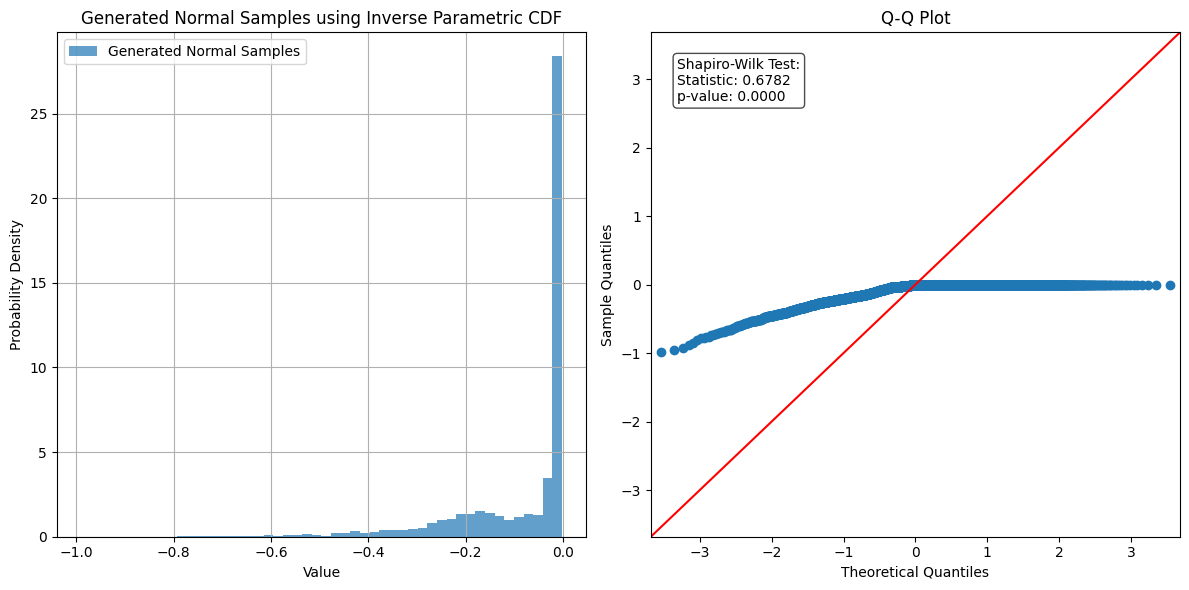

In [80]:
@torch.no_grad()
def evaluate(generator: torch.nn.Module, z_val: torch.Tensor):
    generator.eval()
    with torch.no_grad():
        fake_samples = generator(z_val).cpu()
        ts = fake_samples.numpy().astype(np.float32)

    return ts

gen_sample_size = 5000
z_vals = torch.randn(gen_sample_size, hparams['noise_size'], device=device)
normal_samples = np.array([evaluate(generator, z) for z in z_vals])

# Shapiro-Wilk test
statistic, p_value = shapiro(normal_samples)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Histogram on subplot 1
ax1.hist(normal_samples, bins=50, density=True, alpha=0.7, label='Generated Normal Samples')
ax1.set_title('Generated Normal Samples using Inverse Parametric CDF')
ax1.set_xlabel('Value')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.grid(True)

# Q-Q plot on subplot 2
sm.qqplot(normal_samples, line='45', ax=ax2)
ax2.set_title('Q-Q Plot')
annotation = ax2.annotate(
    f"Shapiro-Wilk Test:\nStatistic: {statistic:.4f}\np-value: {p_value:.4f}",
    xy=(0.05, 0.95),
    xycoords='axes fraction',
    horizontalalignment='left',
    verticalalignment='top',
    fontsize=10,
    bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.7)
)

plt.tight_layout()
plt.show()

# STEP 3

## Estimate ($\theta_1, \theta_2, ...$)

In [2]:
mean = 0
std_dev = 1
sample_size = 10000
ts_length = 200
emb = std_dev * np.abs(np.sin(np.arange(0, ts_length)*2*np.pi/ts_length))
random_points = np.array([np.random.normal(mean, emb, ts_length) for _ in range(sample_size)])

In [ ]:
n_windows = 20
rolling_len = len(random_points[0])//n_windows
uneven_len = rolling_len + len(random_points[0])%n_windows
all_params = []
for i in range(n_windows):
    if i == n_windows - 1:
        rolling_points = random_points[:, -uneven_len:].flatten()
    else:
        rolling_points = random_points[:, rolling_len*i:rolling_len*(i + 1)].flatten()
    all_params.append(beta.fit(rolling_points))

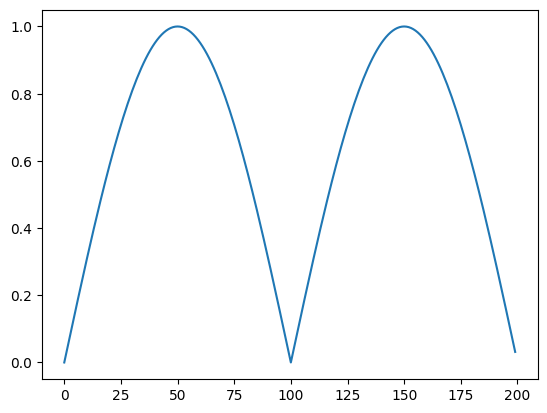

In [3]:
plt.plot(emb)

In [182]:
print(all_params)

[(2183553.7925437875, 1991701.924505039, -355.0262646260712, 678.858772441534), (1010910.3622808412, 1862576.5955419154, -552.8401433624781, 1571.4266458186785), (1107091.6134203859, 144686.45512265933, -2153.9866031760166, 2435.489074349777), (12808522.548361138, 4179959.968291271, -6351.9545475703, 8424.86367126564), (313.8663202722596, 282.2957951341097, -25.262241667711486, 47.99489854305857), (572.7829147376345, 485.1235525742086, -35.05731142207126, 64.7524916011698), (33446.23419753596, 912654.1876747049, -166.51576745811144, 4710.265864260984), (1264866.6185878883, 6718436.670849899, -880.0158521913124, 5554.28398353166), (569718.7685308456, 113460.45711775398, -875.886164710043, 1050.3181605736977), (1890182.096015683, 1621564.8366070038, -388.85732166067316, 722.4540023577662), (2092541.0246149595, 1945817.1095132104, -346.9058041520998, 669.4856002300919), (1037896.5261156822, 1907611.3644123585, -563.3574937398454, 1598.782785763035), (4470194.115843888, 15878.642455867961,

KeyboardInterrupt: 

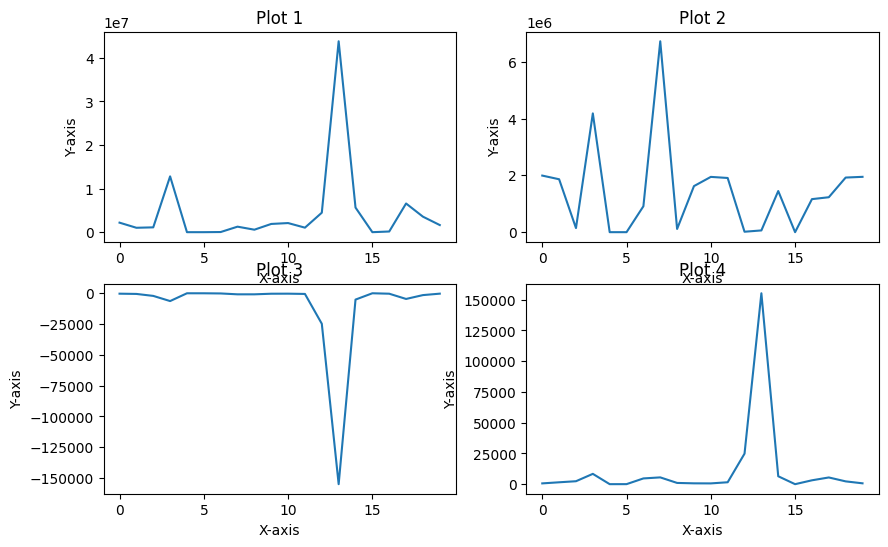

In [187]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i in range(4):
    param_values = [parametrization[i] for parametrization in all_params]
    axes[i // 2, i % 2].plot(param_values)
    axes[i // 2, i % 2].set_title(f"Plot {i + 1}")
    axes[i // 2, i % 2].set_xlabel("X-axis")
    axes[i // 2, i % 2].set_ylabel("Y-axis")

plt.tight_layout()
plt.show()

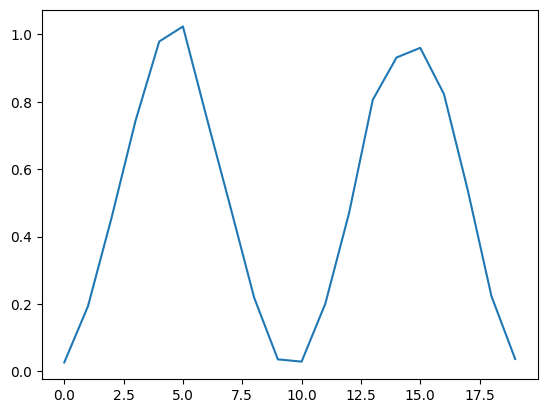

In [177]:
vars = []
for params in all_params:
    gen_sample_size = 50000
    uniform_points = np.random.uniform(0, 1, gen_sample_size)
    normal_samples = beta.ppf(uniform_points, *params)
    vars.append(normal_samples.var())

plt.plot()
plt.plot(vars)

Funciona bé. El problema es que necessitem com més finestres millor per més definició, però perdem dades per a cada finestra. Si les característiques de la sèrie canvien molt ràpidament, pot ser un problema.

## GenNN

In [83]:
class SinosodialVarianceDataset(Dataset):
    """Sinusoidal Variance Time series dataset."""

    def __init__(self, sigma, mu=0, ts_length=100, n_samples=10000, transform=None):
        emb = sigma * np.abs(np.sin(np.arange(0, ts_length)*2*np.pi/ts_length))
        self.random_series = [np.random.normal(mean, emb, ts_length).astype(np.float32) for _ in range(n_samples)]
        self.transform = transform

    def __len__(self):
        return len(self.random_series)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ts = self.random_series[idx]

        sample = {'ts': ts}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 torch.Size([32, 200])
1 torch.Size([32, 200])
2 torch.Size([32, 200])
3 torch.Size([32, 200])


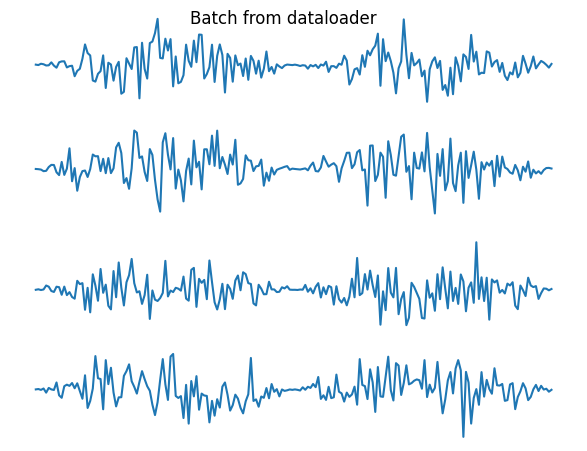

In [118]:
ts_length = 200
bsz = 32

dataset = SinosodialVarianceDataset(sigma=1, mu=0, ts_length=ts_length, n_samples=20000, transform=transforms.Compose([ToTensor()]))

dataloader = DataLoader(dataset, batch_size=bsz, shuffle=True, num_workers=0)

def plot_batch(sample_batched):
    ts_batch = sample_batched['ts']
    batch_size = len(ts_batch)
    n_plotted = min(4, batch_size)

    for i in range(n_plotted):
        ax = plt.subplot(n_plotted, 1, i + 1)
        plt.tight_layout()
        plt.plot(ts_batch[i].numpy())
        ax.axis('off')

    plt.suptitle('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['ts'].size())

    if i_batch == 3:
        plt.figure()
        plot_batch(sample_batched)
        plt.show()
        break

In [119]:
def simplified_experiment(G, D, hparams, scheduler=False):
    generator = G(hparams['noise_size'], hparams['ts_size']).to(device)
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])
    scheduler_g = torch.optim.lr_scheduler.StepLR(optimizer_g, step_size=hparams['step_size_lr_scheduler_g'], gamma=hparams['gamma_g'])

    discriminator = D(hparams['ts_size']).to(device)
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])
    scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_d, step_size=hparams['step_size_lr_scheduler_d'], gamma=hparams['gamma_d'])

    criterion = nn.BCELoss()

    # Train function
    def train_batch(real_samples: torch.Tensor, generator: torch.nn.Module, discriminator: torch.nn.Module, optimizer_g: torch.optim, optimizer_d: torch.optim) -> Tuple[float, float, int, int, int, int, int]:
        generator.train()
        discriminator.train()

        bsz = real_samples.shape[0]

        # Real (ones) and Fake (zeros)
        label_real = torch.ones([bsz, 1])
        label_fake = torch.zeros([bsz, 1])

        label_real = label_real.to(device)
        label_fake = label_fake.to(device)

        ########################
        # OPTIMIZE DISCRIMINATOR
        ########################

        bd_hits_real = 0
        bd_hits_fake = 0
        bd_attempts = bsz * hparams['disc_ratio']

        for _ in range(hparams['disc_ratio']):
            # Generate fake samples
            z = torch.randn(bsz, hparams['noise_size'], device=device)
            fake_samples = generator(z)
            fake_samples = fake_samples.detach() # Freeze the generator

            # Reset gradients
            optimizer_d.zero_grad()

            # Calculate discriminator prediction, loss and #correct predictions for real samples
            predictions_d_real = discriminator(real_samples)
            loss_d_real = criterion(predictions_d_real, label_real)
            bd_hits_real += (predictions_d_real >= 0.5).sum().item()

            # Calculate discriminator prediction, loss and #correct predictions for fake samples
            predictions_d_fake = discriminator(fake_samples)
            loss_d_fake = criterion(predictions_d_fake, label_fake)
            bd_hits_fake += (predictions_d_fake < 0.5).sum().item()

            # Total discriminator loss
            loss_d = (loss_d_real + loss_d_fake)/2
            loss_d.backward()

            # Update step
            optimizer_d.step()

        ####################
        # OPTIMIZE GENERATOR
        ####################

        # Reset gradients
        optimizer_g.zero_grad()

        # Generate fake samples
        z = torch.randn(bsz, hparams['noise_size'], device=device)
        fake_samples = generator(z)

        # Evaluate the generated samples with the discriminator
        predictions_g_fake = discriminator(fake_samples)
        # Calculate error with respect to what the generator wants
        loss_g = criterion(predictions_g_fake, label_real)
        bg_hits = (predictions_g_fake >= 0.5).sum().item()
        bg_attempts = bsz

        # Backpropagate
        loss_g.backward()

        # Update weights (do a step in the optimizer)
        optimizer_g.step()

        return loss_g.item(), loss_d.item(), bd_hits_real, bd_hits_fake, bd_attempts, bg_hits, bg_attempts

    # Train loop
    losses_g = []
    losses_d = []
    disc_real_acc = []
    disc_fake_acc = []
    disc_total_acc = []
    gen_success_rate = []

    for epoch in range(hparams['num_epochs']):
        disc_correct_real = 0
        disc_correct_fake = 0
        total_disc_samples = 0
        gen_fool_succesful = 0
        total_gen_samples = 0

        pbar = tqdm(dataloader, position=0, leave=True)
        pbar.set_description(f"Epoch {epoch+1}/{hparams['num_epochs']}")
        for i, real_samples in enumerate(pbar):
            real_samples = real_samples['ts']
            real_samples = real_samples.to(device)
            loss_g, loss_d, bd_hits_real, bd_hits_fake, bd_attempts, bg_hits, bg_attempts = train_batch(real_samples, generator, discriminator, optimizer_g, optimizer_d)
            if scheduler:
                scheduler_g.step()
                scheduler_d.step()

            disc_correct_real += bd_hits_real
            disc_correct_fake += bd_hits_fake
            total_disc_samples += bd_attempts
            gen_fool_succesful += bg_hits
            total_gen_samples += bg_attempts

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        disc_real_acc.append(disc_correct_real/total_disc_samples)
        disc_fake_acc.append(disc_correct_fake/total_disc_samples)
        disc_total_acc.append((disc_correct_real + disc_correct_fake)/(2*total_disc_samples))
        gen_success_rate.append(gen_fool_succesful/total_gen_samples)

        print(f"--------End of Epoch {epoch+1}/{hparams['num_epochs']}: G_loss: {loss_g:.4f}, D_loss: {loss_d:.4f}, D_real_acc: {disc_correct_real/total_disc_samples:.4f}, " +
              f"D_fake_acc: {disc_correct_fake/total_disc_samples:.4f}, D_total_acc: {(disc_correct_real + disc_correct_fake)/(2*total_disc_samples):.4f}, " +
              f"G_succ_rate: {gen_fool_succesful/total_gen_samples:.4f}")

    source = pd.DataFrame({'Generator': losses_g,
                       'Discriminator': losses_d,
                       'Epoch': np.arange(1, len(losses_g) + 1)})

    ch1 = alt.Chart(source).mark_line().transform_fold(
        fold=['Generator', 'Discriminator'],
        as_=['Network', 'Loss']
    ).encode(
        alt.X('Epoch:Q'),
        alt.Y('Loss:Q'),
        color='Network:N'
    ).properties(height=425, width=750)

    source = pd.DataFrame({'Discriminator real sample accuracy': disc_real_acc,
                       'Discriminator fake sample accuracy': disc_fake_acc,
                       'Epoch': np.arange(1, len(disc_real_acc) + 1)})

    ch2 = alt.Chart(source).mark_line().transform_fold(
        fold=['Discriminator real sample accuracy', 'Discriminator fake sample accuracy'],
        as_=['Type of accuracy', 'Accuracy (%)']
    ).encode(
        alt.X('Epoch:Q'),
        alt.Y('Accuracy (%):Q'),
        color='Type of accuracy:N'
    ).properties(height=425, width=750)

    source = pd.DataFrame({'Generator success rate':gen_success_rate,
                       'Discriminator total accuracy': disc_total_acc,
                       'Epoch': np.arange(1, len(gen_success_rate) + 1)})

    ch3 = alt.Chart(source).mark_line().transform_fold(
        fold=['Generator success rate', 'Discriminator total accuracy'],
        as_=['Type of accuracy', 'Accuracy (%)']
    ).encode(
        alt.X('Epoch:Q'),
        alt.Y('Accuracy (%):Q'),
        color='Type of accuracy:N'
    ).properties(height=425, width=750)

    def plot_batches(real_samples_batch, generated_samples_batched, fooled_disc, generated_mean=0, generated_std=0.1, real_mean=0, real_std=0.1):
        assert len(generated_samples_batched) == len(fooled_disc)
        ts_real_samples = real_samples_batch['ts']
        ts_generated_samples = generated_samples_batched

        data_frames_real = [pd.DataFrame({'Time': np.arange(len(ts)), 'Value': ts.numpy()}) for ts in ts_real_samples]
        data_frames_generated = [pd.DataFrame({'Time': np.arange(len(ts)), 'Value': ts}) for ts in ts_generated_samples]

        charts_real = [alt.Chart(df).mark_line().encode(
                    x='Time',
                    y='Value',
                ).properties(width=300, height=150) for df in data_frames_real]

        charts_generated = [alt.Chart(df, title=alt.TitleParams("Discriminator fooled" if fooled_disc[i] else "Discriminator catch", fontSize=8)).mark_line(color="orange").encode(
                    x='Time',
                    y='Value',
                ).properties(width=300, height=150) for i, df in enumerate(data_frames_generated)]

        combined_chart_real = alt.hconcat(*charts_real)
        combined_chart_generated = alt.hconcat(*charts_generated)

        title_real = "Real Samples (mean={:.2f}, std={:.2f})".format(real_mean, real_std)
        combined_chart_real = alt.hconcat(combined_chart_real).properties(title=title_real)
        title_generated = "Generated Samples (mean={:.2f}, std={:.2f})".format(generated_mean, generated_std)
        combined_chart_generated = alt.hconcat(combined_chart_generated).properties(title=title_generated)

        final_chart = alt.vconcat(combined_chart_real, combined_chart_generated).configure_axis(
            labelFontSize=8,
            titleFontSize=10
        )

        return final_chart

    @torch.no_grad()
    def evaluate(generator: torch.nn.Module, z_val: torch.Tensor):
        generator.eval()
        with torch.no_grad():
            fake_samples = generator(z_val).cpu()
            ts = fake_samples.numpy().astype(np.float32)

        return ts

    @torch.no_grad()
    def disc_output(discriminator: torch.nn.Module, ts: np.ndarray):
        discriminator.eval()
        with torch.no_grad():
            ts = torch.tensor(ts).to(torch.float32).to('cuda')
            predictions = discriminator(ts).cpu()
            result = predictions.numpy().astype(np.float32).flatten()

        return result

    def estimate_mu_sigma(random_walks):
        increments = [np.diff(x) for x in random_walks]

        return np.mean(increments), np.std(increments)

    z_vals = torch.randn(10000, hparams['noise_size'], device=device)
    random_walks = [evaluate(generator, z) for z in z_vals]
    estimated_mu, estimated_sigma = estimate_mu_sigma(random_walks)


    z_val = torch.randn(4, hparams['noise_size'], device=device)
    fooled_disc = disc_output(discriminator, evaluate(generator, z_val)) > 0.5

    ch4 = plot_batches(next(iter(dataloader)), evaluate(generator, z_val), fooled_disc, generated_mean=estimated_mu, generated_std=estimated_sigma)

    return generator, discriminator, [losses_g, losses_d, disc_real_acc, disc_fake_acc, disc_total_acc, gen_success_rate], ch1, ch2, ch3, ch4

In [120]:
hparams = {
    'batch_size':bsz,
    'num_epochs':20,
    'learning_rate':1e-3,
    'betas':(0.5, 0.999),
    'noise_size':10,
    'num_val_samples':4,
    'ts_size':ts_length,
    'disc_ratio': 5,
    'step_size_lr_scheduler_g': 20,
    'step_size_lr_scheduler_d': 20,
    'gamma_g': 0.5,
    'gamma_d': 0.5
}

generator, discriminator, metrics, ch1, ch2, ch3, ch4 = simplified_experiment(models.GeneratorCnn, models.DiscriminatorMlpCnn, hparams)

# Saving charts
ch1.save('Sinusoidalch1.svg')
ch2.save('Sinusoidalch2.svg')
ch3.save('Sinusoidalch3.svg')
ch4.save('Sinusoidalch4.svg')

# Metrics
generator_parameters = filter(lambda p: p.requires_grad, generator.parameters())
generator_n_params = sum([np.prod(p.size()) for p in generator_parameters])
discriminator_parameters = filter(lambda p: p.requires_grad, discriminator.parameters())
discriminator_n_params = sum([np.prod(p.size()) for p in discriminator_parameters])

print("# params. generator: {}".format(generator_n_params))
print("# params. discriminator: {}".format(discriminator_n_params))
print("Loss generator: {:.4f}".format(metrics[0][-1]))
print("Loss discriminator: {:.4f}".format(metrics[1][-1]))
print("Discriminator real accuracy: {:.4f}".format(metrics[2][-1]))
print("Discriminator fake accuracy: {:.4f}".format(metrics[3][-1]))
print("Discriminator total accuracy: {:.4f}".format(metrics[4][-1]))
print("Generator success rate: {:.4f}".format(metrics[5][-1]))

Epoch 1/20: 100%|██████████| 625/625 [01:07<00:00,  9.28it/s]


--------End of Epoch 1/20: G_loss: 1.1799, D_loss: 0.5476, D_real_acc: 0.6836, D_fake_acc: 0.7799, D_total_acc: 0.7318, G_succ_rate: 0.1625


Epoch 2/20: 100%|██████████| 625/625 [00:58<00:00, 10.70it/s]


--------End of Epoch 2/20: G_loss: 0.8480, D_loss: 0.5685, D_real_acc: 0.7333, D_fake_acc: 0.5495, D_total_acc: 0.6414, G_succ_rate: 0.4078


Epoch 3/20: 100%|██████████| 625/625 [00:58<00:00, 10.64it/s]


--------End of Epoch 3/20: G_loss: 0.7731, D_loss: 0.6405, D_real_acc: 0.7072, D_fake_acc: 0.5292, D_total_acc: 0.6182, G_succ_rate: 0.4410


Epoch 4/20: 100%|██████████| 625/625 [00:58<00:00, 10.67it/s]


--------End of Epoch 4/20: G_loss: 0.9961, D_loss: 0.6098, D_real_acc: 0.6845, D_fake_acc: 0.5110, D_total_acc: 0.5977, G_succ_rate: 0.4708


Epoch 5/20: 100%|██████████| 625/625 [00:58<00:00, 10.60it/s]


--------End of Epoch 5/20: G_loss: 0.8615, D_loss: 0.6916, D_real_acc: 0.6805, D_fake_acc: 0.4920, D_total_acc: 0.5862, G_succ_rate: 0.4821


Epoch 6/20: 100%|██████████| 625/625 [00:59<00:00, 10.58it/s]


--------End of Epoch 6/20: G_loss: 0.7872, D_loss: 0.5446, D_real_acc: 0.6767, D_fake_acc: 0.4920, D_total_acc: 0.5843, G_succ_rate: 0.4809


Epoch 7/20: 100%|██████████| 625/625 [00:58<00:00, 10.61it/s]


--------End of Epoch 7/20: G_loss: 0.7477, D_loss: 0.6729, D_real_acc: 0.4341, D_fake_acc: 0.7782, D_total_acc: 0.6062, G_succ_rate: 0.2014


Epoch 8/20: 100%|██████████| 625/625 [00:58<00:00, 10.62it/s]


--------End of Epoch 8/20: G_loss: 0.7638, D_loss: 0.6745, D_real_acc: 0.4226, D_fake_acc: 0.7625, D_total_acc: 0.5925, G_succ_rate: 0.2288


Epoch 9/20: 100%|██████████| 625/625 [00:58<00:00, 10.62it/s]


--------End of Epoch 9/20: G_loss: 0.6982, D_loss: 0.6299, D_real_acc: 0.4775, D_fake_acc: 0.6631, D_total_acc: 0.5703, G_succ_rate: 0.3317


Epoch 10/20: 100%|██████████| 625/625 [00:58<00:00, 10.61it/s]


--------End of Epoch 10/20: G_loss: 0.7498, D_loss: 0.6187, D_real_acc: 0.4617, D_fake_acc: 0.6909, D_total_acc: 0.5763, G_succ_rate: 0.2973


Epoch 11/20: 100%|██████████| 625/625 [00:59<00:00, 10.49it/s]


--------End of Epoch 11/20: G_loss: 0.7841, D_loss: 0.6178, D_real_acc: 0.4703, D_fake_acc: 0.6562, D_total_acc: 0.5633, G_succ_rate: 0.3303


Epoch 12/20: 100%|██████████| 625/625 [00:59<00:00, 10.45it/s]


--------End of Epoch 12/20: G_loss: 0.7139, D_loss: 0.6876, D_real_acc: 0.4680, D_fake_acc: 0.6370, D_total_acc: 0.5525, G_succ_rate: 0.3446


Epoch 13/20: 100%|██████████| 625/625 [01:00<00:00, 10.36it/s]


--------End of Epoch 13/20: G_loss: 0.8230, D_loss: 0.6279, D_real_acc: 0.4786, D_fake_acc: 0.6440, D_total_acc: 0.5613, G_succ_rate: 0.3424


Epoch 14/20: 100%|██████████| 625/625 [01:00<00:00, 10.28it/s]


--------End of Epoch 14/20: G_loss: 0.8353, D_loss: 0.5737, D_real_acc: 0.4619, D_fake_acc: 0.6564, D_total_acc: 0.5591, G_succ_rate: 0.3281


Epoch 15/20: 100%|██████████| 625/625 [00:59<00:00, 10.49it/s]


--------End of Epoch 15/20: G_loss: 0.8148, D_loss: 0.7423, D_real_acc: 0.4956, D_fake_acc: 0.6022, D_total_acc: 0.5489, G_succ_rate: 0.3798


Epoch 16/20: 100%|██████████| 625/625 [00:59<00:00, 10.55it/s]


--------End of Epoch 16/20: G_loss: 0.6792, D_loss: 0.6244, D_real_acc: 0.4909, D_fake_acc: 0.6095, D_total_acc: 0.5502, G_succ_rate: 0.3784


Epoch 17/20: 100%|██████████| 625/625 [00:59<00:00, 10.57it/s]


--------End of Epoch 17/20: G_loss: 0.7328, D_loss: 0.6771, D_real_acc: 0.4829, D_fake_acc: 0.6244, D_total_acc: 0.5537, G_succ_rate: 0.3648


Epoch 18/20: 100%|██████████| 625/625 [00:59<00:00, 10.56it/s]


--------End of Epoch 18/20: G_loss: 0.6962, D_loss: 0.6960, D_real_acc: 0.4790, D_fake_acc: 0.6302, D_total_acc: 0.5546, G_succ_rate: 0.3534


Epoch 19/20: 100%|██████████| 625/625 [00:59<00:00, 10.59it/s]


--------End of Epoch 19/20: G_loss: 0.7253, D_loss: 0.6528, D_real_acc: 0.4709, D_fake_acc: 0.6256, D_total_acc: 0.5482, G_succ_rate: 0.3618


Epoch 20/20: 100%|██████████| 625/625 [00:59<00:00, 10.57it/s]


--------End of Epoch 20/20: G_loss: 0.6934, D_loss: 0.7007, D_real_acc: 0.4678, D_fake_acc: 0.6472, D_total_acc: 0.5575, G_succ_rate: 0.3376
# params. generator: 328501
# params. discriminator: 100327
Loss generator: 0.6934
Loss discriminator: 0.7007
Discriminator real accuracy: 0.4678
Discriminator fake accuracy: 0.6472
Discriminator total accuracy: 0.5575
Generator success rate: 0.3376


In [121]:
ch1

alt.Chart(...)

In [122]:
ch2

alt.Chart(...)

In [123]:
ch3

alt.Chart(...)

In [124]:
ch4

alt.VConcatChart(...)

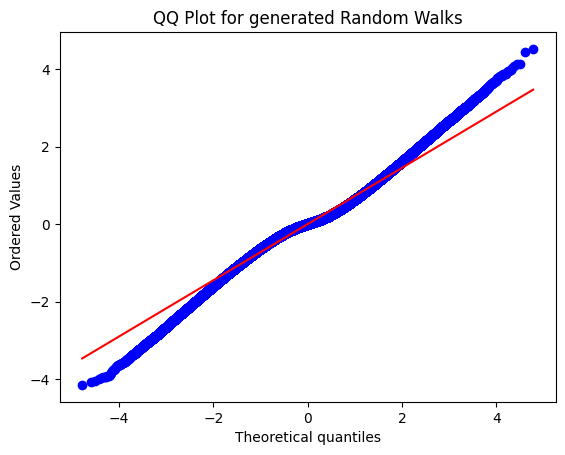

The data does not follow a normal distribution (p-value = 0.0000000000)


D:\Desktop\Time series\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


<Figure size 640x480 with 0 Axes>

In [125]:
qq_plot = evaluation.normality_test(generator, hparams, device)

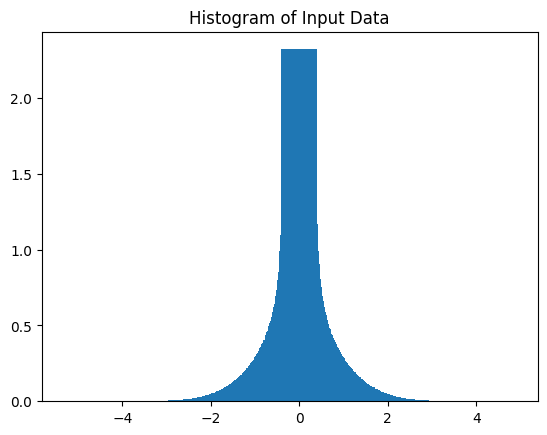

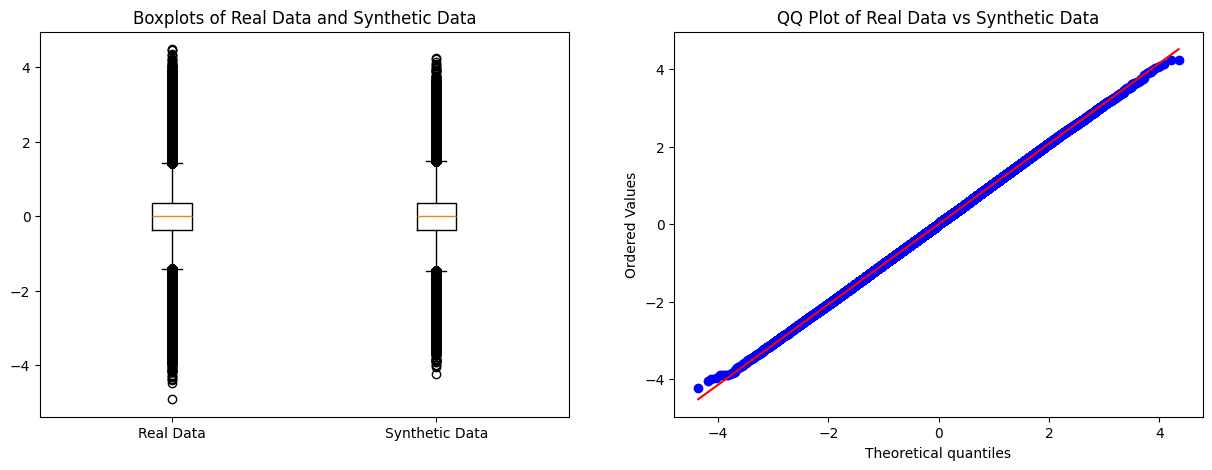

In [126]:
evaluation.original_distribution_test(dataloader, generator, hparams, device)

In [127]:
@torch.no_grad()
def evaluate(generator: torch.nn.Module, z_val: torch.Tensor):
    generator.eval()
    with torch.no_grad():
        fake_samples = generator(z_val).cpu()
        ts = fake_samples.numpy().astype(np.float32)

    return ts

all_data = []
for batch in dataloader:
    for sample in batch['ts']:
        all_data.append(sample.tolist())
real_stds = [np.std(position) for position in np.array(all_data).T]

z_vals = torch.randn(50000, hparams['noise_size'], device=device)
fake_series = np.array([evaluate(generator, z) for z in z_vals])
fake_stds = [np.std(position) for position in fake_series.T]

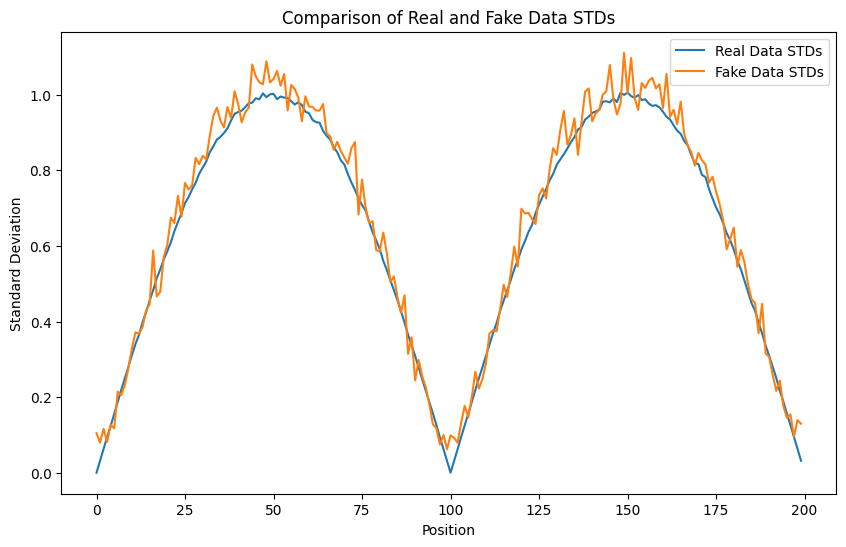

In [128]:
plt.figure(figsize=(10, 6))
plt.plot(real_stds, label='Real Data STDs')
plt.plot(fake_stds, label='Fake Data STDs')
plt.xlabel('Position')
plt.ylabel('Standard Deviation')

plt.title('Comparison of Real and Fake Data STDs')
plt.legend()

plt.show()

# STEP 4

## Estimate ($\theta_1, \theta_2, ...$)

In [4]:
mean = 0
std_dev = 1
sample_size = 100000
group_size = 1
ts_length = 2000

data = []
for i in range(sample_size):
    n_peaks = np.random.uniform(1, 5)
    emb = std_dev * np.abs(np.sin(np.arange(0, ts_length)*n_peaks*np.pi/ts_length))
    random_group = np.array([np.random.normal(mean, emb, ts_length) for _ in range(group_size)])
    data.append(random_group)

In [5]:
n_windows = 20
rolling_len = ts_length//n_windows
uneven_len = rolling_len + ts_length%n_windows
all_params = []

for random_points in data:
    series_params = []
    for i in range(n_windows):
        if i == n_windows - 1:
            rolling_points = random_points[:, -uneven_len:].flatten()
        else:
            rolling_points = random_points[:, rolling_len*i:rolling_len*(i + 1)].flatten()
        e_mu = rolling_points.mean()
        e_sigma_2 = rolling_points.var()
        series_params.append((e_mu, e_sigma_2, 0, 0))
    all_params.append(series_params)

In [8]:
"""
n_windows = 20
rolling_len = ts_length//n_windows
uneven_len = rolling_len + ts_length%n_windows
all_params = []

for random_points in data:
    series_params = []
    for i in range(n_windows):
        if i == n_windows - 1:
            rolling_points = random_points[:, -uneven_len:].flatten()
        else:
            rolling_points = random_points[:, rolling_len*i:rolling_len*(i + 1)].flatten()
        series_params.append(beta.fit(rolling_points))
    all_params.append(series_params)
"""

'\nn_windows = 20\nrolling_len = ts_length//n_windows\nuneven_len = rolling_len + ts_length%n_windows\nall_params = []\n\nfor random_points in data:\n    series_params = []\n    for i in range(n_windows):\n        if i == n_windows - 1:\n            rolling_points = random_points[:, -uneven_len:].flatten()\n        else:\n            rolling_points = random_points[:, rolling_len*i:rolling_len*(i + 1)].flatten()\n        series_params.append(beta.fit(rolling_points))\n    all_params.append(series_params)\n'

In [25]:
class TimeSeriesParameterSpaceDataset(Dataset):
    """Multiple Sinusoidal Variance Time series dataset."""

    def __init__(self, all_params, transform=None):
        self.all_params = np.array(all_params)[:, :, 1].astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.all_params)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ts = self.all_params[idx]

        sample = {'ts': ts}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [26]:
bsz = 16

dataset = TimeSeriesParameterSpaceDataset(all_params, transform=transforms.Compose([ToTensor()]))

dataloader = DataLoader(dataset, batch_size=bsz, shuffle=True, num_workers=0)

0 torch.Size([16, 20])
1 torch.Size([16, 20])
2 torch.Size([16, 20])
3 torch.Size([16, 20])


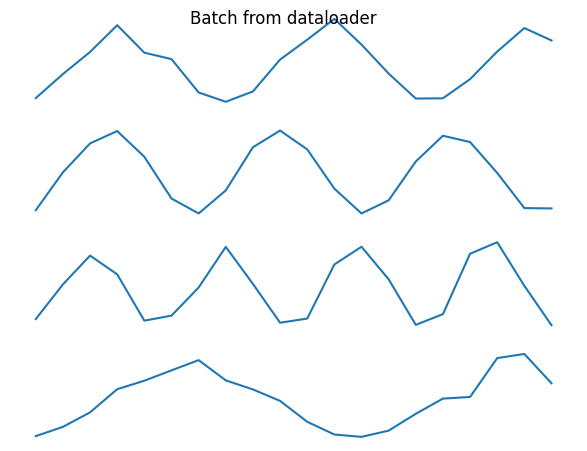

In [27]:
def plot_batch(sample_batched):
    ts_batch = sample_batched['ts']
    batch_size = len(ts_batch)
    n_plotted = min(4, batch_size)

    for i in range(n_plotted):
        ax = plt.subplot(n_plotted, 1, i + 1)
        plt.tight_layout()
        plt.plot(ts_batch[i].numpy())
        ax.axis('off')

    plt.suptitle('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['ts'].size())

    if i_batch == 3:
        plt.figure()
        plot_batch(sample_batched)
        plt.show()
        break

In [12]:
class Generator(torch.nn.Module):
    def __init__(self, noise_size: int, ts_size: int, dimensionality: int):
        super().__init__()
        self.ts_size = ts_size
        self.dimensionality = dimensionality

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=noise_size, out_features=128),
            nn.Tanh(),
        )
        self.fc2 = nn.Linear(in_features=128, out_features=ts_size * dimensionality)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.fc2(x)

        return x.reshape(-1, self.ts_size, self.dimensionality)


class GeneratorMlp(torch.nn.Module):
    def __init__(self, noise_size: int, ts_size: int, dimensionality: int):
        super().__init__()
        self.ts_size = ts_size
        self.dimensionality = dimensionality
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=noise_size, out_features=max(ts_size // 4, 1)),
            nn.Tanh()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=max(ts_size // 4, 1), out_features=max(ts_size // 2, 1)),
            nn.Tanh()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=max(ts_size // 2, 1), out_features=ts_size * dimensionality),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x.reshape(-1, self.ts_size, self.dimensionality)


"""
class GeneratorMlpBatchnorm(torch.nn.Module):
    def __init__(self, noise_size: int, ts_size: int, dimensionality: int):
        super().__init__()
        self.ts_size = ts_size
        self.dimensionality = dimensionality
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=noise_size, out_features=max(ts_size // 64, 1)),
            nn.BatchNorm1d(max(ts_size // 64, 1)),
            nn.Tanh()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=max(ts_size // 64, 1), out_features=max(ts_size // 4, 1)),
            nn.BatchNorm1d(max(ts_size // 4, 1)),
            nn.Tanh()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=max(ts_size // 4, 1), out_features=ts_size * dimensionality),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Reshape input tensor to have 2D shape (batch_size, features)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # Reshape output tensor to have 3D shape (batch_size, ts_size, dimensionality)
        x = x.view(-1, self.ts_size, self.dimensionality)
        return x
"""


class ownUpsample(nn.Module):
    def __init__(self, scale_factor, mode='nearest', align_corners=False):
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners=align_corners

    def forward(self, x):
        B, C, dimensionality, ts_length = x.size()
        x = x.reshape(B, C*dimensionality, ts_length)
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        x = x.reshape(B, C, dimensionality, ts_length)
        return x


class GeneratorCnn(torch.nn.Module):
    def __init__(self, noise_size: int, ts_size: int, dimensionality: int):
        super().__init__()
        self.ts_size = ts_size
        self.dimensionality = dimensionality
        self.linear = nn.Linear(in_features=noise_size, out_features=max(-(ts_size // -64), 1))  # ceiling division
        self.tconv1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(4, 5), padding="same"),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.tconv2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 5), padding="same"),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.tconv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 5), padding="same"),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.tconv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 5), padding="same"),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.tconv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 10), padding="same"),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 7), padding="same"),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 5), padding="same"),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(1, 1), stride=(1, 2), padding=(0, 4)),
            # nn.Tanh()
        )

    def upsample(self, x: torch.Tensor, scaling_factor: int):
        B, C, dimensionality, ts_length = x.size()
        x = x.reshape(B, C*dimensionality, ts_length)
        upsampler = nn.Upsample(scale_factor=2)
        x = upsampler(x)
        x = x.reshape(B, C, dimensionality, -1)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear(x)

        if x.dim() == 1:
            x = x.unsqueeze(0)

        x = x.unsqueeze(2).unsqueeze(3)

        x = self.tconv1(x)
        x = self.tconv2(x)

        x = self.upsample(x, 2)
        x = self.tconv3(x)
        x = self.upsample(x, 2)
        x = self.tconv4(x)
        x = self.upsample(x, 2)
        x = self.tconv5(x)

        x = self.proj(x)

        x = torch.permute(x, (0, 1, 3, 2))
        x = torch.squeeze(x)


        return x.reshape(-1, self.ts_size, self.dimensionality)




class Discriminator(torch.nn.Module):
    def __init__(self, ts_size: int, dimensionality: int):
        super().__init__()
        self.ts_size = ts_size
        self.dimensionality = dimensionality
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=ts_size*dimensionality, out_features=1),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape(-1, self.ts_size*self.dimensionality)
        x = self.fc1(x)

        return x


class DiscriminatorMlpCnn(torch.nn.Module):
    def __init__(self, ts_size: int, dimensionality: int):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5, 4), padding="same"),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 4), padding="same"),
            nn.LeakyReLU(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 4), padding="same"),
            nn.LeakyReLU(0.2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*ts_size*dimensionality, out_features=3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=3, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unsqueeze(1)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        bsz, _, _, _ = x.shape
        x = x.reshape(bsz, -1)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [40]:
def simplified_experiment(G, D, hparams, scheduler=False):
    generator = G(hparams['noise_size'], hparams['ts_size']).to(device)
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])
    scheduler_g = torch.optim.lr_scheduler.StepLR(optimizer_g, step_size=hparams['step_size_lr_scheduler_g'], gamma=hparams['gamma_g'])

    discriminator = D(hparams['ts_size']).to(device)
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])
    scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_d, step_size=hparams['step_size_lr_scheduler_d'], gamma=hparams['gamma_d'])

    criterion = nn.BCELoss()

    # Train function
    def train_batch(real_samples: torch.Tensor, generator: torch.nn.Module, discriminator: torch.nn.Module, optimizer_g: torch.optim, optimizer_d: torch.optim) -> Tuple[float, float, int, int, int, int, int]:
        generator.train()
        discriminator.train()

        bsz = real_samples.shape[0]

        # Real (ones) and Fake (zeros)
        label_real = torch.ones([bsz, 1])
        label_fake = torch.zeros([bsz, 1])

        label_real = label_real.to(device)
        label_fake = label_fake.to(device)

        ########################
        # OPTIMIZE DISCRIMINATOR
        ########################

        bd_hits_real = 0
        bd_hits_fake = 0
        bd_attempts = bsz * hparams['disc_ratio']

        for _ in range(hparams['disc_ratio']):
            # Generate fake samples
            z = torch.randn(bsz, hparams['noise_size'], device=device)
            fake_samples = generator(z)
            fake_samples = fake_samples.detach() # Freeze the generator

            # Reset gradients
            optimizer_d.zero_grad()

            # Calculate discriminator prediction, loss and #correct predictions for real samples
            predictions_d_real = discriminator(real_samples)
            loss_d_real = criterion(predictions_d_real, label_real)
            bd_hits_real += (predictions_d_real >= 0.5).sum().item()

            # Calculate discriminator prediction, loss and #correct predictions for fake samples
            predictions_d_fake = discriminator(fake_samples)
            loss_d_fake = criterion(predictions_d_fake, label_fake)
            bd_hits_fake += (predictions_d_fake < 0.5).sum().item()

            # Total discriminator loss
            loss_d = (loss_d_real + loss_d_fake)/2
            loss_d.backward()

            # Update step
            optimizer_d.step()

        ####################
        # OPTIMIZE GENERATOR
        ####################

        # Reset gradients
        optimizer_g.zero_grad()

        # Generate fake samples
        z = torch.randn(bsz, hparams['noise_size'], device=device)
        fake_samples = generator(z)

        # Evaluate the generated samples with the discriminator
        predictions_g_fake = discriminator(fake_samples)
        # Calculate error with respect to what the generator wants
        loss_g = criterion(predictions_g_fake, label_real)
        bg_hits = (predictions_g_fake >= 0.5).sum().item()
        bg_attempts = bsz

        # Backpropagate
        loss_g.backward()

        # Update weights (do a step in the optimizer)
        optimizer_g.step()

        return loss_g.item(), loss_d.item(), bd_hits_real, bd_hits_fake, bd_attempts, bg_hits, bg_attempts

    # Train loop
    losses_g = []
    losses_d = []
    disc_real_acc = []
    disc_fake_acc = []
    disc_total_acc = []
    gen_success_rate = []

    for epoch in range(hparams['num_epochs']):
        disc_correct_real = 0
        disc_correct_fake = 0
        total_disc_samples = 0
        gen_fool_succesful = 0
        total_gen_samples = 0

        pbar = tqdm(dataloader, position=0, leave=True)
        pbar.set_description(f"Epoch {epoch+1}/{hparams['num_epochs']}")
        for i, real_samples in enumerate(pbar):
            real_samples = real_samples['ts']
            real_samples = real_samples.to(device)
            loss_g, loss_d, bd_hits_real, bd_hits_fake, bd_attempts, bg_hits, bg_attempts = train_batch(real_samples, generator, discriminator, optimizer_g, optimizer_d)
            if scheduler:
                scheduler_g.step()
                scheduler_d.step()

            disc_correct_real += bd_hits_real
            disc_correct_fake += bd_hits_fake
            total_disc_samples += bd_attempts
            gen_fool_succesful += bg_hits
            total_gen_samples += bg_attempts

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        disc_real_acc.append(disc_correct_real/total_disc_samples)
        disc_fake_acc.append(disc_correct_fake/total_disc_samples)
        disc_total_acc.append((disc_correct_real + disc_correct_fake)/(2*total_disc_samples))
        gen_success_rate.append(gen_fool_succesful/total_gen_samples)

        print(f"--------End of Epoch {epoch+1}/{hparams['num_epochs']}: G_loss: {loss_g:.4f}, D_loss: {loss_d:.4f}, D_real_acc: {disc_correct_real/total_disc_samples:.4f}, " +
              f"D_fake_acc: {disc_correct_fake/total_disc_samples:.4f}, D_total_acc: {(disc_correct_real + disc_correct_fake)/(2*total_disc_samples):.4f}, " +
              f"G_succ_rate: {gen_fool_succesful/total_gen_samples:.4f}")

    source = pd.DataFrame({'Generator': losses_g,
                       'Discriminator': losses_d,
                       'Epoch': np.arange(1, len(losses_g) + 1)})

    ch1 = alt.Chart(source).mark_line().transform_fold(
        fold=['Generator', 'Discriminator'],
        as_=['Network', 'Loss']
    ).encode(
        alt.X('Epoch:Q'),
        alt.Y('Loss:Q'),
        color='Network:N'
    ).properties(height=425, width=750)

    source = pd.DataFrame({'Discriminator real sample accuracy': disc_real_acc,
                       'Discriminator fake sample accuracy': disc_fake_acc,
                       'Epoch': np.arange(1, len(disc_real_acc) + 1)})

    ch2 = alt.Chart(source).mark_line().transform_fold(
        fold=['Discriminator real sample accuracy', 'Discriminator fake sample accuracy'],
        as_=['Type of accuracy', 'Accuracy (%)']
    ).encode(
        alt.X('Epoch:Q'),
        alt.Y('Accuracy (%):Q'),
        color='Type of accuracy:N'
    ).properties(height=425, width=750)

    source = pd.DataFrame({'Generator success rate':gen_success_rate,
                       'Discriminator total accuracy': disc_total_acc,
                       'Epoch': np.arange(1, len(gen_success_rate) + 1)})

    ch3 = alt.Chart(source).mark_line().transform_fold(
        fold=['Generator success rate', 'Discriminator total accuracy'],
        as_=['Type of accuracy', 'Accuracy (%)']
    ).encode(
        alt.X('Epoch:Q'),
        alt.Y('Accuracy (%):Q'),
        color='Type of accuracy:N'
    ).properties(height=425, width=750)

    def plot_batches(real_samples_batch, generated_samples_batched, fooled_disc, generated_mean=0, generated_std=0.1, real_mean=0, real_std=0.1):
        assert len(generated_samples_batched) == len(fooled_disc)
        ts_real_samples = real_samples_batch['ts']
        ts_generated_samples = generated_samples_batched

        data_frames_real = [pd.DataFrame({'Time': np.arange(len(ts)), 'Value': ts.numpy()}) for ts in ts_real_samples]
        data_frames_generated = [pd.DataFrame({'Time': np.arange(len(ts)), 'Value': ts}) for ts in ts_generated_samples]

        charts_real = [alt.Chart(df).mark_line().encode(
                    x='Time',
                    y='Value',
                ).properties(width=300, height=150) for df in data_frames_real]

        charts_generated = [alt.Chart(df, title=alt.TitleParams("Discriminator fooled" if fooled_disc[i] else "Discriminator catch", fontSize=8)).mark_line(color="orange").encode(
                    x='Time',
                    y='Value',
                ).properties(width=300, height=150) for i, df in enumerate(data_frames_generated)]

        combined_chart_real = alt.hconcat(*charts_real)
        combined_chart_generated = alt.hconcat(*charts_generated)

        title_real = "Real Samples (mean={:.2f}, std={:.2f})".format(real_mean, real_std)
        combined_chart_real = alt.hconcat(combined_chart_real).properties(title=title_real)
        title_generated = "Generated Samples (mean={:.2f}, std={:.2f})".format(generated_mean, generated_std)
        combined_chart_generated = alt.hconcat(combined_chart_generated).properties(title=title_generated)

        final_chart = alt.vconcat(combined_chart_real, combined_chart_generated).configure_axis(
            labelFontSize=8,
            titleFontSize=10
        )

        return final_chart

    @torch.no_grad()
    def evaluate(generator: torch.nn.Module, z_val: torch.Tensor):
        generator.eval()
        with torch.no_grad():
            fake_samples = generator(z_val).cpu()
            ts = fake_samples.numpy().astype(np.float32)

        return ts

    @torch.no_grad()
    def disc_output(discriminator: torch.nn.Module, ts: np.ndarray):
        discriminator.eval()
        with torch.no_grad():
            ts = torch.tensor(ts).to(torch.float32).to('cuda')
            predictions = discriminator(ts).cpu()
            result = predictions.numpy().astype(np.float32).flatten()

        return result

    def estimate_mu_sigma(random_walks):
        increments = [np.diff(x) for x in random_walks]

        return np.mean(increments), np.std(increments)

    z_vals = torch.randn(10000, hparams['noise_size'], device=device)
    random_walks = [evaluate(generator, z) for z in z_vals]
    estimated_mu, estimated_sigma = estimate_mu_sigma(random_walks)


    z_val = torch.randn(bsz, hparams['noise_size'], device=device)
    fooled_disc = disc_output(discriminator, evaluate(generator, z_val)) > 0.5

    ch4 = plot_batches(next(iter(dataloader)), evaluate(generator, z_val), fooled_disc, generated_mean=estimated_mu, generated_std=estimated_sigma)

    return generator, discriminator, [losses_g, losses_d, disc_real_acc, disc_fake_acc, disc_total_acc, gen_success_rate], ch1, ch2, ch3, ch4

In [41]:
hparams = {
    'batch_size':bsz,
    'num_epochs':1,
    'learning_rate':1e-4,
    'betas':(0.5, 0.999),
    'noise_size':10,
    'num_val_samples':4,
    'ts_size':20,
    'dimensionality':4,
    'disc_ratio': 5,
    'step_size_lr_scheduler_g': 20,
    'step_size_lr_scheduler_d': 20,
    'gamma_g': 0.5,
    'gamma_d': 0.5
}

generator, discriminator, metrics, ch1, ch2, ch3, ch4 = simplified_experiment(GeneratorCnn, DiscriminatorMlpCnn, hparams)

# Saving charts
ch1.save('_MultipleSinusoidalch1.svg')
ch2.save('_MultipleSinusoidalch2.svg')
ch3.save('_MultipleSinusoidalch3.svg')
ch4.save('_MultipleSinusoidalch4.svg')

# Metrics
generator_parameters = filter(lambda p: p.requires_grad, generator.parameters())
generator_n_params = sum([np.prod(p.size()) for p in generator_parameters])
discriminator_parameters = filter(lambda p: p.requires_grad, discriminator.parameters())
discriminator_n_params = sum([np.prod(p.size()) for p in discriminator_parameters])

print("# params. generator: {}".format(generator_n_params))
print("# params. discriminator: {}".format(discriminator_n_params))
print("Loss generator: {:.4f}".format(metrics[0][-1]))
print("Loss discriminator: {:.4f}".format(metrics[1][-1]))
print("Discriminator real accuracy: {:.4f}".format(metrics[2][-1]))
print("Discriminator fake accuracy: {:.4f}".format(metrics[3][-1]))
print("Discriminator total accuracy: {:.4f}".format(metrics[4][-1]))
print("Generator success rate: {:.4f}".format(metrics[5][-1]))

Epoch 1/1: 100%|██████████| 6250/6250 [06:33<00:00, 15.89it/s]


--------End of Epoch 1/1: G_loss: 0.8967, D_loss: 0.5665, D_real_acc: 0.4454, D_fake_acc: 0.7996, D_total_acc: 0.6225, G_succ_rate: 0.1814
# params. generator: 278368
# params. discriminator: 65767
Loss generator: 0.8967
Loss discriminator: 0.5665
Discriminator real accuracy: 0.4454
Discriminator fake accuracy: 0.7996
Discriminator total accuracy: 0.6225
Generator success rate: 0.1814


In [42]:
ch1

alt.Chart(...)

In [43]:
ch2

alt.Chart(...)

In [44]:
ch3

alt.Chart(...)

In [45]:
ch4

alt.VConcatChart(...)

Falta tenir una red neuronal capaç de generar evolucions de parametres

Per evitar la no-smoothness dels parametres, com veiem al gràfic quatri-partit, s'ha de fer l'enforcing de la constraint de smoothness (gradient dels parametres). Per això

El paràmeter space sembla molt caòtic utilitzant aquesta parametrització.

In [46]:
"""
@torch.no_grad()
def evaluate(generator: torch.nn.Module, z_val: torch.Tensor):
    generator.eval()
    with torch.no_grad():
        fake_samples = generator(z_val).cpu()
        ts = fake_samples.numpy().astype(np.float32)

    return ts

all_data = []
for batch in dataloader:
    for sample in batch['ts']:
        all_data.append(sample.tolist())
real_stds = [np.std(position) for position in np.array(all_data).T]

z_vals = torch.randn(1, hparams['noise_size'], device=device)
fake_series = np.array([evaluate(generator, z) for z in z_vals])
for series in fake_series:
    gen_sample_size = 50000
    uniform_points = np.random.uniform(0, 1, gen_sample_size)
    normal_samples = beta.ppf(uniform_points, *params)
print("done")
fake_stds = [np.std(position) for position in fake_series.T]

vars = []
for params in all_params:
    gen_sample_size = 50000
    uniform_points = np.random.uniform(0, 1, gen_sample_size)
    normal_samples = beta.ppf(uniform_points, *params)
    vars.append(normal_samples.var())

plt.plot()
plt.plot(vars)
""";

In [ ]:
@torch.no_grad()
def evaluate(generator: torch.nn.Module, z_val: torch.Tensor):
    generator.eval()
    with torch.no_grad():
        fake_samples = generator(z_val).cpu()
        ts = fake_samples.numpy().astype(np.float32)

    return ts

all_data = []
for batch in dataloader:
    for sample in batch['ts']:
        all_data.append(sample.tolist())
real_stds = np.sqrt(np.mean(np.array(all_data)**2, axis=0))  # Mean of variances, return to std

z_vals = torch.randn(10000, hparams['noise_size'], device=device)
fake_series = np.array([evaluate(generator, z) for z in z_vals]).squeeze()
fake_stds = np.sqrt(np.mean(fake_series**2, axis=0))  # Mean of variances, return to std

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(real_stds, label='Real Data STDs')
plt.plot(fake_stds, label='Fake Data STDs')
plt.xlabel('Position')
plt.ylabel('Standard Deviation')

plt.title('Comparison of Real and Fake Data STDs')
plt.legend()

plt.show()

In [ ]:
# Problema podria venir de la red generativa. Intentarem demà generar només variancies sabent que la resta es tot estable. (amb la red antiga)

## GenNN

In [196]:
class MultipleSinosodialVarianceDataset(Dataset):
    """Multiple Sinusoidal Variance Time series dataset."""

    def __init__(self, sigma, mu=0, ts_length=100, n_samples=10000, transform=None):
        self.random_series = [np.random.normal(mean, sigma * np.abs(np.sin(np.arange(0, ts_length)*np.random.uniform(1, 5)*np.pi/ts_length)), ts_length).astype(np.float32) for _ in range(n_samples)]
        self.transform = transform

    def __len__(self):
        return len(self.random_series)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        ts = self.random_series[idx]

        sample = {'ts': ts}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 torch.Size([32, 200])
1 torch.Size([32, 200])
2 torch.Size([32, 200])
3 torch.Size([32, 200])


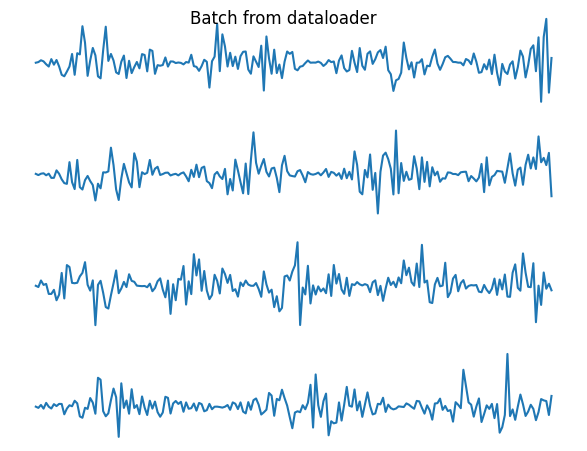

In [197]:
ts_length = 200
bsz = 32

dataset = MultipleSinosodialVarianceDataset(sigma=1, mu=0, ts_length=ts_length, n_samples=20000, transform=transforms.Compose([ToTensor()]))

dataloader = DataLoader(dataset, batch_size=bsz, shuffle=True, num_workers=0)

def plot_batch(sample_batched):
    ts_batch = sample_batched['ts']
    batch_size = len(ts_batch)
    n_plotted = min(4, batch_size)

    for i in range(n_plotted):
        ax = plt.subplot(n_plotted, 1, i + 1)
        plt.tight_layout()
        plt.plot(ts_batch[i].numpy())
        ax.axis('off')

    plt.suptitle('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['ts'].size())

    if i_batch == 3:
        plt.figure()
        plot_batch(sample_batched)
        plt.show()
        break

In [198]:
def simplified_experiment(G, D, hparams, scheduler=False):
    generator = G(hparams['noise_size'], hparams['ts_size']).to(device)
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])
    scheduler_g = torch.optim.lr_scheduler.StepLR(optimizer_g, step_size=hparams['step_size_lr_scheduler_g'], gamma=hparams['gamma_g'])

    discriminator = D(hparams['ts_size']).to(device)
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])
    scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_d, step_size=hparams['step_size_lr_scheduler_d'], gamma=hparams['gamma_d'])

    criterion = nn.BCELoss()

    # Train function
    def train_batch(real_samples: torch.Tensor, generator: torch.nn.Module, discriminator: torch.nn.Module, optimizer_g: torch.optim, optimizer_d: torch.optim) -> Tuple[float, float, int, int, int, int, int]:
        generator.train()
        discriminator.train()

        bsz = real_samples.shape[0]

        # Real (ones) and Fake (zeros)
        label_real = torch.ones([bsz, 1])
        label_fake = torch.zeros([bsz, 1])

        label_real = label_real.to(device)
        label_fake = label_fake.to(device)

        ########################
        # OPTIMIZE DISCRIMINATOR
        ########################

        bd_hits_real = 0
        bd_hits_fake = 0
        bd_attempts = bsz * hparams['disc_ratio']

        for _ in range(hparams['disc_ratio']):
            # Generate fake samples
            z = torch.randn(bsz, hparams['noise_size'], device=device)
            fake_samples = generator(z)
            fake_samples = fake_samples.detach() # Freeze the generator

            # Reset gradients
            optimizer_d.zero_grad()

            # Calculate discriminator prediction, loss and #correct predictions for real samples
            predictions_d_real = discriminator(real_samples)
            loss_d_real = criterion(predictions_d_real, label_real)
            bd_hits_real += (predictions_d_real >= 0.5).sum().item()

            # Calculate discriminator prediction, loss and #correct predictions for fake samples
            predictions_d_fake = discriminator(fake_samples)
            loss_d_fake = criterion(predictions_d_fake, label_fake)
            bd_hits_fake += (predictions_d_fake < 0.5).sum().item()

            # Total discriminator loss
            loss_d = (loss_d_real + loss_d_fake)/2
            loss_d.backward()

            # Update step
            optimizer_d.step()

        ####################
        # OPTIMIZE GENERATOR
        ####################

        # Reset gradients
        optimizer_g.zero_grad()

        # Generate fake samples
        z = torch.randn(bsz, hparams['noise_size'], device=device)
        fake_samples = generator(z)

        # Evaluate the generated samples with the discriminator
        predictions_g_fake = discriminator(fake_samples)
        # Calculate error with respect to what the generator wants
        loss_g = criterion(predictions_g_fake, label_real)
        bg_hits = (predictions_g_fake >= 0.5).sum().item()
        bg_attempts = bsz

        # Backpropagate
        loss_g.backward()

        # Update weights (do a step in the optimizer)
        optimizer_g.step()

        return loss_g.item(), loss_d.item(), bd_hits_real, bd_hits_fake, bd_attempts, bg_hits, bg_attempts

    # Train loop
    losses_g = []
    losses_d = []
    disc_real_acc = []
    disc_fake_acc = []
    disc_total_acc = []
    gen_success_rate = []

    for epoch in range(hparams['num_epochs']):
        disc_correct_real = 0
        disc_correct_fake = 0
        total_disc_samples = 0
        gen_fool_succesful = 0
        total_gen_samples = 0

        pbar = tqdm(dataloader, position=0, leave=True)
        pbar.set_description(f"Epoch {epoch+1}/{hparams['num_epochs']}")
        for i, real_samples in enumerate(pbar):
            real_samples = real_samples['ts']
            real_samples = real_samples.to(device)
            loss_g, loss_d, bd_hits_real, bd_hits_fake, bd_attempts, bg_hits, bg_attempts = train_batch(real_samples, generator, discriminator, optimizer_g, optimizer_d)
            if scheduler:
                scheduler_g.step()
                scheduler_d.step()

            disc_correct_real += bd_hits_real
            disc_correct_fake += bd_hits_fake
            total_disc_samples += bd_attempts
            gen_fool_succesful += bg_hits
            total_gen_samples += bg_attempts

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        disc_real_acc.append(disc_correct_real/total_disc_samples)
        disc_fake_acc.append(disc_correct_fake/total_disc_samples)
        disc_total_acc.append((disc_correct_real + disc_correct_fake)/(2*total_disc_samples))
        gen_success_rate.append(gen_fool_succesful/total_gen_samples)

        print(f"--------End of Epoch {epoch+1}/{hparams['num_epochs']}: G_loss: {loss_g:.4f}, D_loss: {loss_d:.4f}, D_real_acc: {disc_correct_real/total_disc_samples:.4f}, " +
              f"D_fake_acc: {disc_correct_fake/total_disc_samples:.4f}, D_total_acc: {(disc_correct_real + disc_correct_fake)/(2*total_disc_samples):.4f}, " +
              f"G_succ_rate: {gen_fool_succesful/total_gen_samples:.4f}")

    source = pd.DataFrame({'Generator': losses_g,
                       'Discriminator': losses_d,
                       'Epoch': np.arange(1, len(losses_g) + 1)})

    ch1 = alt.Chart(source).mark_line().transform_fold(
        fold=['Generator', 'Discriminator'],
        as_=['Network', 'Loss']
    ).encode(
        alt.X('Epoch:Q'),
        alt.Y('Loss:Q'),
        color='Network:N'
    ).properties(height=425, width=750)

    source = pd.DataFrame({'Discriminator real sample accuracy': disc_real_acc,
                       'Discriminator fake sample accuracy': disc_fake_acc,
                       'Epoch': np.arange(1, len(disc_real_acc) + 1)})

    ch2 = alt.Chart(source).mark_line().transform_fold(
        fold=['Discriminator real sample accuracy', 'Discriminator fake sample accuracy'],
        as_=['Type of accuracy', 'Accuracy (%)']
    ).encode(
        alt.X('Epoch:Q'),
        alt.Y('Accuracy (%):Q'),
        color='Type of accuracy:N'
    ).properties(height=425, width=750)

    source = pd.DataFrame({'Generator success rate':gen_success_rate,
                       'Discriminator total accuracy': disc_total_acc,
                       'Epoch': np.arange(1, len(gen_success_rate) + 1)})

    ch3 = alt.Chart(source).mark_line().transform_fold(
        fold=['Generator success rate', 'Discriminator total accuracy'],
        as_=['Type of accuracy', 'Accuracy (%)']
    ).encode(
        alt.X('Epoch:Q'),
        alt.Y('Accuracy (%):Q'),
        color='Type of accuracy:N'
    ).properties(height=425, width=750)

    def plot_batches(real_samples_batch, generated_samples_batched, fooled_disc, generated_mean=0, generated_std=0.1, real_mean=0, real_std=0.1):
        assert len(generated_samples_batched) == len(fooled_disc)
        ts_real_samples = real_samples_batch['ts']
        ts_generated_samples = generated_samples_batched

        data_frames_real = [pd.DataFrame({'Time': np.arange(len(ts)), 'Value': ts.numpy()}) for ts in ts_real_samples]
        data_frames_generated = [pd.DataFrame({'Time': np.arange(len(ts)), 'Value': ts}) for ts in ts_generated_samples]

        charts_real = [alt.Chart(df).mark_line().encode(
                    x='Time',
                    y='Value',
                ).properties(width=300, height=150) for df in data_frames_real]

        charts_generated = [alt.Chart(df, title=alt.TitleParams("Discriminator fooled" if fooled_disc[i] else "Discriminator catch", fontSize=8)).mark_line(color="orange").encode(
                    x='Time',
                    y='Value',
                ).properties(width=300, height=150) for i, df in enumerate(data_frames_generated)]

        combined_chart_real = alt.hconcat(*charts_real)
        combined_chart_generated = alt.hconcat(*charts_generated)

        title_real = "Real Samples (mean={:.2f}, std={:.2f})".format(real_mean, real_std)
        combined_chart_real = alt.hconcat(combined_chart_real).properties(title=title_real)
        title_generated = "Generated Samples (mean={:.2f}, std={:.2f})".format(generated_mean, generated_std)
        combined_chart_generated = alt.hconcat(combined_chart_generated).properties(title=title_generated)

        final_chart = alt.vconcat(combined_chart_real, combined_chart_generated).configure_axis(
            labelFontSize=8,
            titleFontSize=10
        )

        return final_chart

    @torch.no_grad()
    def evaluate(generator: torch.nn.Module, z_val: torch.Tensor):
        generator.eval()
        with torch.no_grad():
            fake_samples = generator(z_val).cpu()
            ts = fake_samples.numpy().astype(np.float32)

        return ts

    @torch.no_grad()
    def disc_output(discriminator: torch.nn.Module, ts: np.ndarray):
        discriminator.eval()
        with torch.no_grad():
            ts = torch.tensor(ts).to(torch.float32).to('cuda')
            predictions = discriminator(ts).cpu()
            result = predictions.numpy().astype(np.float32).flatten()

        return result

    def estimate_mu_sigma(random_walks):
        increments = [np.diff(x) for x in random_walks]

        return np.mean(increments), np.std(increments)

    z_vals = torch.randn(10000, hparams['noise_size'], device=device)
    random_walks = [evaluate(generator, z) for z in z_vals]
    estimated_mu, estimated_sigma = estimate_mu_sigma(random_walks)


    z_val = torch.randn(4, hparams['noise_size'], device=device)
    fooled_disc = disc_output(discriminator, evaluate(generator, z_val)) > 0.5

    ch4 = plot_batches(next(iter(dataloader)), evaluate(generator, z_val), fooled_disc, generated_mean=estimated_mu, generated_std=estimated_sigma)

    return generator, discriminator, [losses_g, losses_d, disc_real_acc, disc_fake_acc, disc_total_acc, gen_success_rate], ch1, ch2, ch3, ch4

In [199]:
hparams = {
    'batch_size':bsz,
    'num_epochs':20,
    'learning_rate':1e-3,
    'betas':(0.5, 0.999),
    'noise_size':10,
    'num_val_samples':4,
    'ts_size':ts_length,
    'disc_ratio': 5,
    'step_size_lr_scheduler_g': 20,
    'step_size_lr_scheduler_d': 20,
    'gamma_g': 0.5,
    'gamma_d': 0.5
}

generator, discriminator, metrics, ch1, ch2, ch3, ch4 = simplified_experiment(models.GeneratorCnn, models.DiscriminatorMlpCnn, hparams)

# Saving charts
ch1.save('MultipleSinusoidalch1.svg')
ch2.save('MultipleSinusoidalch2.svg')
ch3.save('MultipleSinusoidalch3.svg')
ch4.save('MultipleSinusoidalch4.svg')

# Metrics
generator_parameters = filter(lambda p: p.requires_grad, generator.parameters())
generator_n_params = sum([np.prod(p.size()) for p in generator_parameters])
discriminator_parameters = filter(lambda p: p.requires_grad, discriminator.parameters())
discriminator_n_params = sum([np.prod(p.size()) for p in discriminator_parameters])

print("# params. generator: {}".format(generator_n_params))
print("# params. discriminator: {}".format(discriminator_n_params))
print("Loss generator: {:.4f}".format(metrics[0][-1]))
print("Loss discriminator: {:.4f}".format(metrics[1][-1]))
print("Discriminator real accuracy: {:.4f}".format(metrics[2][-1]))
print("Discriminator fake accuracy: {:.4f}".format(metrics[3][-1]))
print("Discriminator total accuracy: {:.4f}".format(metrics[4][-1]))
print("Generator success rate: {:.4f}".format(metrics[5][-1]))

Epoch 1/20: 100%|██████████| 625/625 [01:05<00:00,  9.48it/s]


--------End of Epoch 1/20: G_loss: 2.7012, D_loss: 0.3476, D_real_acc: 0.8264, D_fake_acc: 0.7481, D_total_acc: 0.7873, G_succ_rate: 0.1855


Epoch 2/20: 100%|██████████| 625/625 [00:58<00:00, 10.68it/s]


--------End of Epoch 2/20: G_loss: 1.8011, D_loss: 0.3698, D_real_acc: 0.8446, D_fake_acc: 0.6546, D_total_acc: 0.7496, G_succ_rate: 0.2958


Epoch 3/20: 100%|██████████| 625/625 [00:58<00:00, 10.66it/s]


--------End of Epoch 3/20: G_loss: 2.0178, D_loss: 0.3889, D_real_acc: 0.8465, D_fake_acc: 0.6583, D_total_acc: 0.7524, G_succ_rate: 0.2825


Epoch 4/20: 100%|██████████| 625/625 [00:58<00:00, 10.64it/s]


--------End of Epoch 4/20: G_loss: 1.4530, D_loss: 0.3830, D_real_acc: 0.8440, D_fake_acc: 0.6503, D_total_acc: 0.7472, G_succ_rate: 0.3004


Epoch 5/20: 100%|██████████| 625/625 [00:58<00:00, 10.64it/s]


--------End of Epoch 5/20: G_loss: 2.0377, D_loss: 0.4070, D_real_acc: 0.8385, D_fake_acc: 0.6497, D_total_acc: 0.7441, G_succ_rate: 0.3036


Epoch 6/20: 100%|██████████| 625/625 [00:58<00:00, 10.64it/s]


--------End of Epoch 6/20: G_loss: 1.8256, D_loss: 0.4499, D_real_acc: 0.8289, D_fake_acc: 0.6406, D_total_acc: 0.7347, G_succ_rate: 0.3107


Epoch 7/20: 100%|██████████| 625/625 [00:58<00:00, 10.63it/s]


--------End of Epoch 7/20: G_loss: 1.1698, D_loss: 0.4652, D_real_acc: 0.8252, D_fake_acc: 0.6357, D_total_acc: 0.7305, G_succ_rate: 0.3235


Epoch 8/20: 100%|██████████| 625/625 [00:58<00:00, 10.63it/s]


--------End of Epoch 8/20: G_loss: 1.2925, D_loss: 0.4881, D_real_acc: 0.8174, D_fake_acc: 0.6261, D_total_acc: 0.7218, G_succ_rate: 0.3327


Epoch 9/20: 100%|██████████| 625/625 [01:00<00:00, 10.40it/s]


--------End of Epoch 9/20: G_loss: 1.2815, D_loss: 0.5245, D_real_acc: 0.8146, D_fake_acc: 0.6176, D_total_acc: 0.7161, G_succ_rate: 0.3427


Epoch 10/20: 100%|██████████| 625/625 [01:01<00:00, 10.13it/s]


--------End of Epoch 10/20: G_loss: 1.5444, D_loss: 0.4738, D_real_acc: 0.8009, D_fake_acc: 0.6141, D_total_acc: 0.7075, G_succ_rate: 0.3445


Epoch 11/20: 100%|██████████| 625/625 [01:00<00:00, 10.27it/s]


--------End of Epoch 11/20: G_loss: 1.4395, D_loss: 0.4490, D_real_acc: 0.7918, D_fake_acc: 0.5970, D_total_acc: 0.6944, G_succ_rate: 0.3648


Epoch 12/20: 100%|██████████| 625/625 [00:59<00:00, 10.57it/s]


--------End of Epoch 12/20: G_loss: 1.1246, D_loss: 0.4963, D_real_acc: 0.7961, D_fake_acc: 0.6017, D_total_acc: 0.6989, G_succ_rate: 0.3543


Epoch 13/20: 100%|██████████| 625/625 [00:59<00:00, 10.55it/s]


--------End of Epoch 13/20: G_loss: 1.7441, D_loss: 0.4143, D_real_acc: 0.7909, D_fake_acc: 0.6014, D_total_acc: 0.6961, G_succ_rate: 0.3568


Epoch 14/20: 100%|██████████| 625/625 [00:59<00:00, 10.55it/s]


--------End of Epoch 14/20: G_loss: 1.3066, D_loss: 0.4756, D_real_acc: 0.7884, D_fake_acc: 0.6024, D_total_acc: 0.6954, G_succ_rate: 0.3611


Epoch 15/20: 100%|██████████| 625/625 [00:59<00:00, 10.55it/s]


--------End of Epoch 15/20: G_loss: 1.6047, D_loss: 0.4194, D_real_acc: 0.7811, D_fake_acc: 0.5932, D_total_acc: 0.6872, G_succ_rate: 0.3741


Epoch 16/20: 100%|██████████| 625/625 [00:59<00:00, 10.55it/s]


--------End of Epoch 16/20: G_loss: 1.1756, D_loss: 0.5263, D_real_acc: 0.7757, D_fake_acc: 0.5846, D_total_acc: 0.6802, G_succ_rate: 0.3867


Epoch 17/20: 100%|██████████| 625/625 [00:59<00:00, 10.54it/s]


--------End of Epoch 17/20: G_loss: 1.2021, D_loss: 0.5135, D_real_acc: 0.7712, D_fake_acc: 0.5862, D_total_acc: 0.6787, G_succ_rate: 0.3803


Epoch 18/20: 100%|██████████| 625/625 [00:59<00:00, 10.53it/s]


--------End of Epoch 18/20: G_loss: 1.1444, D_loss: 0.4619, D_real_acc: 0.7712, D_fake_acc: 0.5848, D_total_acc: 0.6780, G_succ_rate: 0.3795


Epoch 19/20: 100%|██████████| 625/625 [00:59<00:00, 10.50it/s]


--------End of Epoch 19/20: G_loss: 1.2806, D_loss: 0.4770, D_real_acc: 0.7708, D_fake_acc: 0.5840, D_total_acc: 0.6774, G_succ_rate: 0.3857


Epoch 20/20: 100%|██████████| 625/625 [00:59<00:00, 10.46it/s]


--------End of Epoch 20/20: G_loss: 1.4318, D_loss: 0.4410, D_real_acc: 0.7710, D_fake_acc: 0.5827, D_total_acc: 0.6768, G_succ_rate: 0.3861
# params. generator: 328501
# params. discriminator: 100327
Loss generator: 1.4318
Loss discriminator: 0.4410
Discriminator real accuracy: 0.7710
Discriminator fake accuracy: 0.5827
Discriminator total accuracy: 0.6768
Generator success rate: 0.3861


In [200]:
ch1

alt.Chart(...)

In [201]:
ch2

alt.Chart(...)

In [202]:
ch3

alt.Chart(...)

In [203]:
ch4

alt.VConcatChart(...)

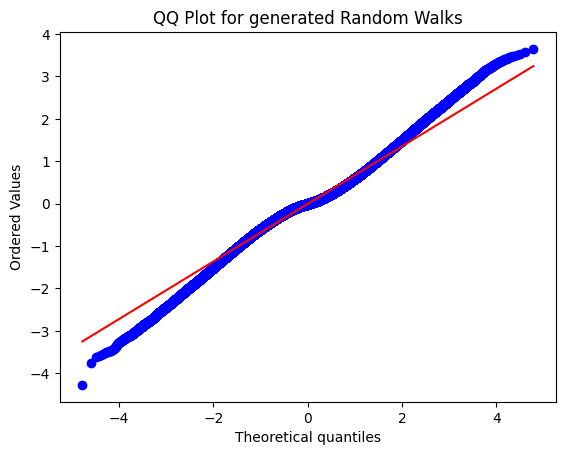

D:\Desktop\Time series\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The data does not follow a normal distribution (p-value = 0.0000000000)


<Figure size 640x480 with 0 Axes>

In [204]:
qq_plot = evaluation.normality_test(generator, hparams, device)

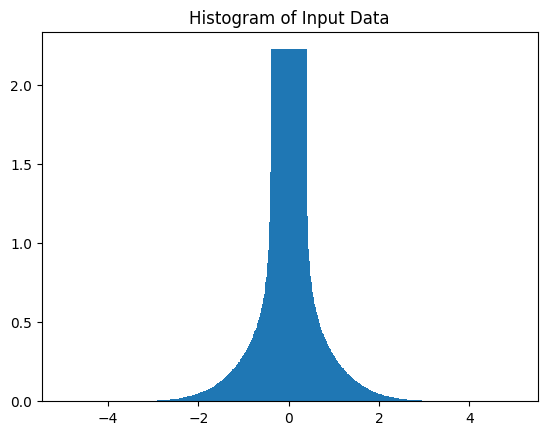

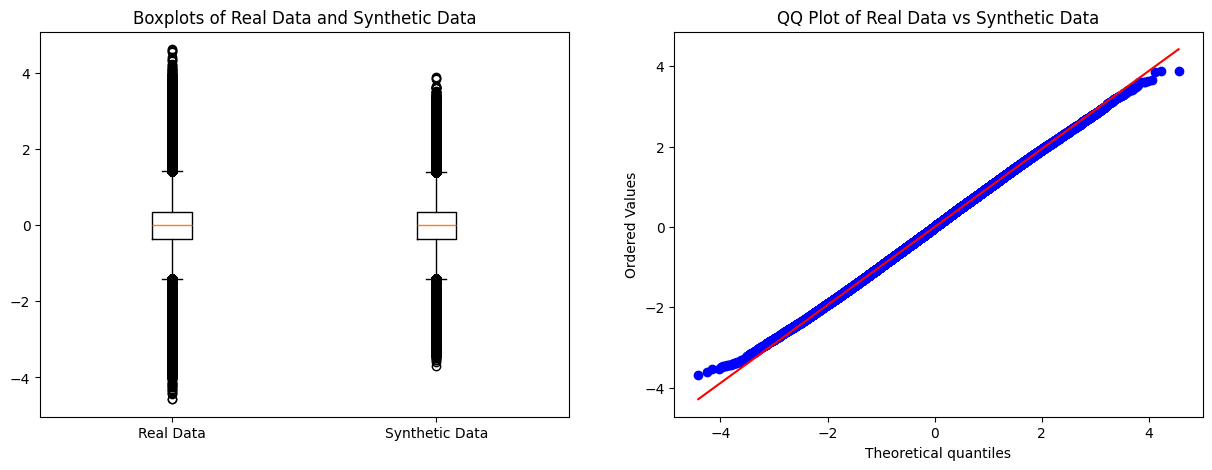

In [205]:
evaluation.original_distribution_test(dataloader, generator, hparams, device)

In [206]:
@torch.no_grad()
def evaluate(generator: torch.nn.Module, z_val: torch.Tensor):
    generator.eval()
    with torch.no_grad():
        fake_samples = generator(z_val).cpu()
        ts = fake_samples.numpy().astype(np.float32)

    return ts

all_data = []
for batch in dataloader:
    for sample in batch['ts']:
        all_data.append(sample.tolist())
real_stds = [np.std(position) for position in np.array(all_data).T]

z_vals = torch.randn(50000, hparams['noise_size'], device=device)
fake_series = np.array([evaluate(generator, z) for z in z_vals])
fake_stds = [np.std(position) for position in fake_series.T]

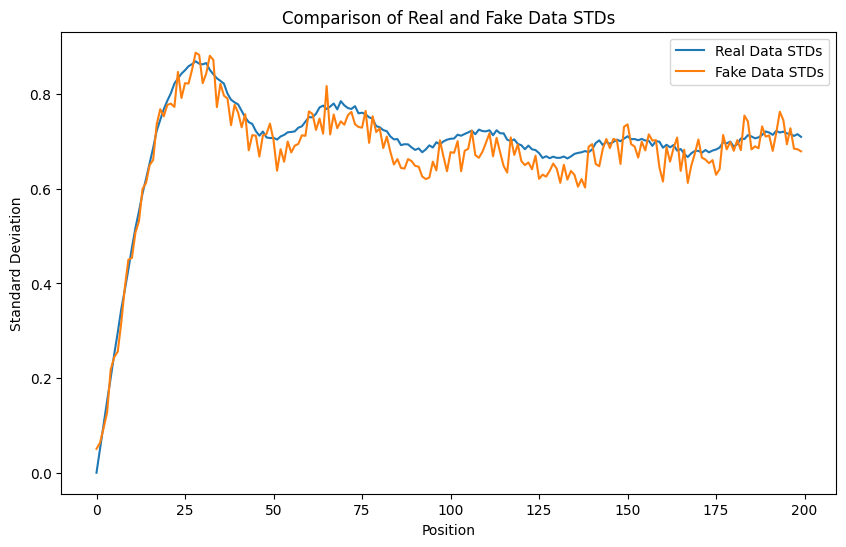

In [207]:
plt.figure(figsize=(10, 6))
plt.plot(real_stds, label='Real Data STDs')
plt.plot(fake_stds, label='Fake Data STDs')
plt.xlabel('Position')
plt.ylabel('Standard Deviation')

plt.title('Comparison of Real and Fake Data STDs')
plt.legend()

plt.show()

In [ ]:
# Podem mirar que la mitjana de número de mínims i la variancia de número de mínims concordin amb lo que sabem de les dades reals, que tenen un número de mínims seguint una uniforme (0, 1)